In [1]:
import pandas as pd
from uta import solve_lp_problem, plot_utility_functions, create_full_ranking_df, check_consistency

In [2]:
df = pd.read_csv('Nuclear waste management.csv', index_col=0)

In [3]:
preferential_information = [(5, 1), (11, 24), (14, 27)]
indifference_information = [(3, 7), (22, 23)]

In [4]:
problem, u_vars, criteria, breakpoints = solve_lp_problem(df, preferential_information, indifference_information, verbose=False)

Kryteria: ['C1', 'C2', 'C3', 'C4']
Stworzono zmienną decyzyjną: epsilon o dolnym ograniczeniu 0
Dodano funkcję celu: epsilon
Dodano ograniczenia wynikające z rankingu referencyjnego
Dodano ograniczenia wynikające z normalizacji i nieujemnosci
Dodano ograniczenia wynikające z monotoniczności
Ostateczny problem do rozwiązania:
Status: Optimal


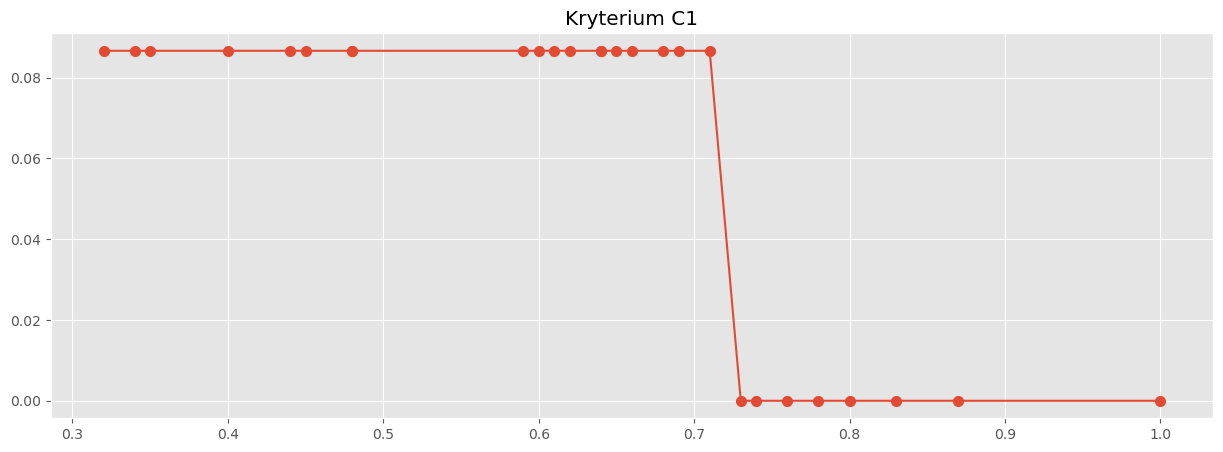

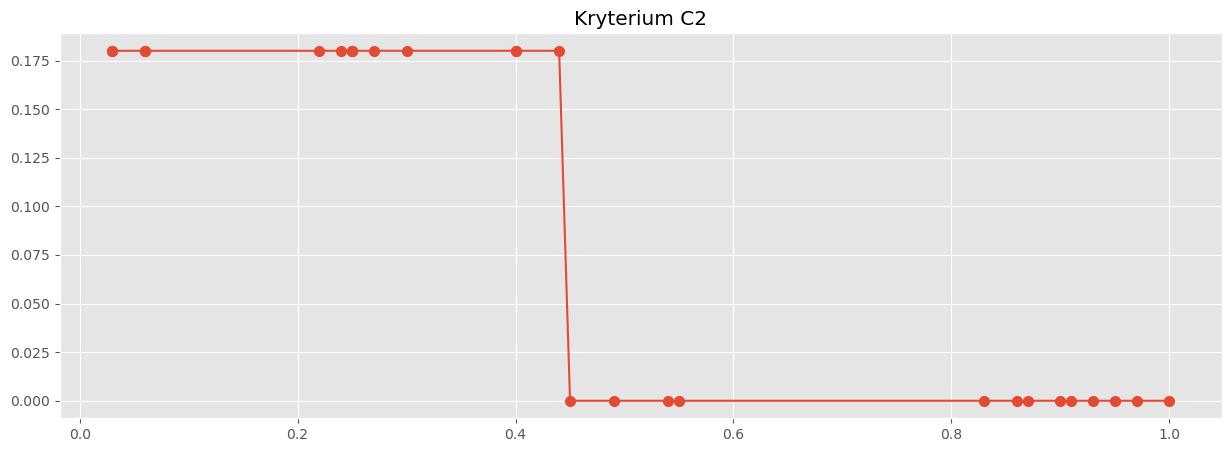

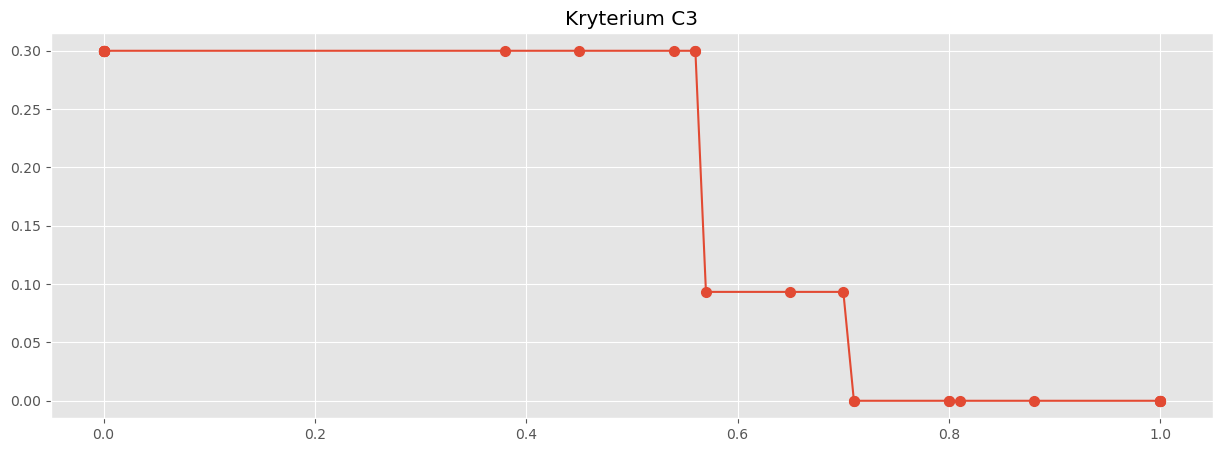

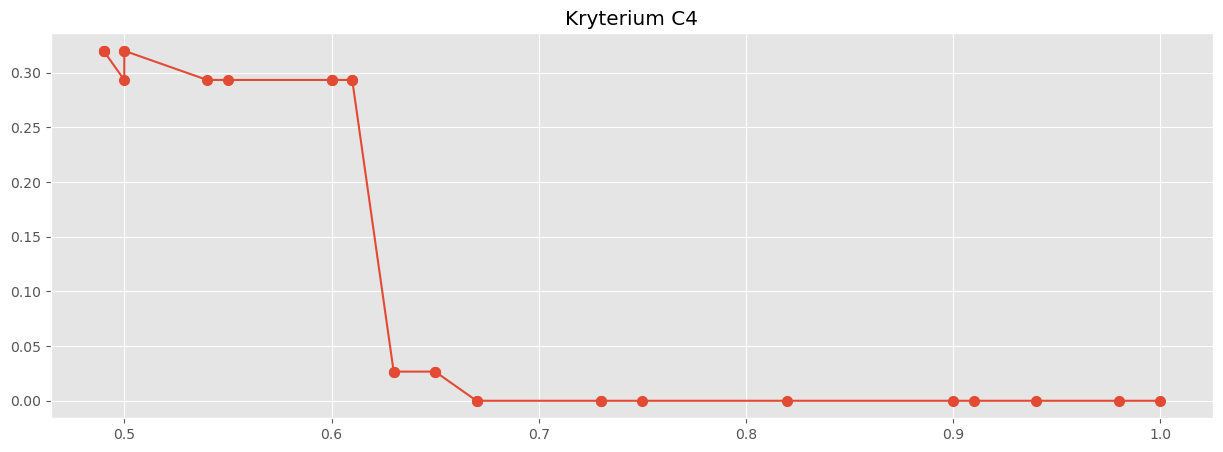

In [5]:
plot_utility_functions(problem, u_vars, criteria, breakpoints)

Brzydki ostatni wykres - inne wartosci f.uzytecznosci czastk. dla wariantow majacych taka sama wartosc na danym kryterium - dziwne, ale na slajdach w ten sposob jest problem formułowany (nierówność nieostra):

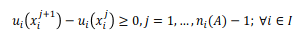

In [6]:
rank = create_full_ranking_df(df, problem, criteria)

In [7]:
check_consistency(rank, preferential_information, indifference_information)

True

In [8]:
rank.sort_values(by='U', ascending=False)

,C1,C2,C3,C4,u1,u2,u3,u4,U
5,0.62,0.40,0.56,0.50,0.086667,0.18,0.3,0.32,0.886667
8,0.64,0.44,0.54,0.54,0.086667,0.18,0.3,0.293333,0.86
11,0.61,0.54,0.38,0.49,0.086667,0.0,0.3,0.32,0.706667
2,0.66,0.55,0.45,0.49,0.086667,0.0,0.3,0.32,0.706667
14,0.69,0.49,0.56,0.61,0.086667,0.0,0.3,0.293333,0.68
17,0.68,0.40,0.65,0.60,0.086667,0.18,0.093333,0.293333,0.653333
9,0.65,0.30,0.71,0.55,0.086667,0.18,0.0,0.293333,0.56
6,0.78,0.27,0.71,0.50,0.0,0.18,0.0,0.32,0.5
12,0.74,0.25,0.80,0.49,0.0,0.18,0.0,0.32,0.5
18,0.76,0.06,1.00,0.60,0.0,0.18,0.0,0.293333,0.473333
